In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
TARGET = "attack_cat" 


In [6]:
df = pd.read_csv("C:\\Users\\Gökhan\\Desktop\\Gökhan\\nids-adversarial\\data\\with_attack_cat_clear_data.csv", low_memory=False)

In [7]:
df['attack_cat'] = df['attack_cat'].astype(str).str.lower().str.strip()

In [8]:
print("Benzersiz sınıflar:", df['attack_cat'].unique())

Benzersiz sınıflar: ['normal' 'exploits' 'reconnaissance' 'dos' 'generic' 'shellcode'
 'fuzzers' 'worms' 'backdoors' 'analysis' 'backdoor']


In [9]:
# # X'e hedefi ve varsa 'label'ı ALMA (label -> leakage)
TARGET = 'attack_cat'
drop_cols = [TARGET]
if 'Label' in df.columns:
    drop_cols.append('Label')
X = df.drop(columns=drop_cols)
y = df[TARGET]
    
# %80 / %20 split (stratified)\n",
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
print("Train class dist:", y_train.value_counts(normalize=True).round(3))
print("Test class dist:", y_test.value_counts(normalize=True).round(3))

Train class dist: attack_cat
normal            0.874
generic           0.085
exploits          0.018
fuzzers           0.010
dos               0.006
reconnaissance    0.006
analysis          0.001
backdoor          0.001
shellcode         0.001
backdoors         0.000
worms             0.000
Name: proportion, dtype: float64
Test class dist: attack_cat
normal            0.874
generic           0.085
exploits          0.018
fuzzers           0.010
dos               0.006
reconnaissance    0.006
analysis          0.001
backdoor          0.001
shellcode         0.001
backdoors         0.000
worms             0.000
Name: proportion, dtype: float64


In [10]:
mlp_params = dict(
    hidden_layer_sizes=(128, 64),  # 2 hidden layer: 128 ve 64 neuron
    activation='relu',
    solver='adam',
    alpha=1e-4,                    # L2 regularization
    learning_rate_init=1e-3,
    max_iter=50,                   # ilk denemede düşük tut, gerekirse artırırsın
    random_state=42
)

mlp_model = Pipeline([
    ("scaler", StandardScaler()),          # feature'ları ölçekle
    ("mlp", MLPClassifier(**mlp_params)),  # MLP modeli
])

In [11]:
X_train.shape, y_train.shape

((2032020, 42), (2032020,))

In [12]:
X_test.shape, y_test.shape

((508006, 42), (508006,))

In [13]:
# 2) Kolon tiplerini belirleyelim
# Sayısal/kategorik ayrımı: object ve category -> kategorik; geri kalan -> sayısal varsayımı
def split_columns(X_train, target):
    cols = [c for c in X_train.columns if c != target]
    cat_cols = []
    num_cols = []

    for c in cols:
        if X_train[c].dtype.name in ["object", "category"]:
            cat_cols.append(c)
        else:
            # Çok-unique ve sayısal görünümlü object'ler varsa dönüştürmeyi düşünebilirsiniz.
            num_cols.append(c)

    return num_cols, cat_cols

num_cols, cat_cols = split_columns(X_train, TARGET)
print("Numeric:", len(num_cols), "\nCategorical:", len(cat_cols))


Numeric: 39 
Categorical: 3


In [14]:
print("Categorical features:", cat_cols)

Categorical features: ['proto', 'state', 'ct_ftp_cmd']


In [15]:
# Counting the unique values of the categorical features...

for col_name in X_train.columns:
    if X_train[col_name].dtypes == 'object':
        unique_cat = len(X_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique values.".format(col_name = col_name, unique_cat = unique_cat))

Feature 'proto' has 134 unique values.
Feature 'state' has 15 unique values.
Feature 'ct_ftp_cmd' has 9 unique values.


In [16]:
def normalize_col(s: pd.Series):
    return s.astype(str).str.lower().str.strip().fillna("unknown")

def pick_top_categories(s: pd.Series, k=6):
    return normalize_col(s).value_counts().head(k).index.tolist()

def add_binary_flags(df: pd.DataFrame, col: str, keep: list, add_other=True, drop_original=True):
    s = normalize_col(df[col])
    for cat in keep:
        new_col = f"is_{col}_{cat}"
        df[new_col] = (s == cat).astype("uint8")
    if add_other:
        df[f"is_{col}_other"] = (~s.isin(keep)).astype("uint8")
    if drop_original:
        df.drop(columns=[col], inplace=True)
    return df

In [17]:
top_proto = pick_top_categories(X_train['proto'], k=6)

X_train = add_binary_flags(X_train, 'proto', top_proto, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'proto', top_proto, add_other=True, drop_original=True)

In [18]:
top_state = pick_top_categories(X_train['state'], k = 6)

X_train = add_binary_flags(X_train, 'state', top_state, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'state', top_state, add_other=True, drop_original=True)

In [19]:
top_ct = pick_top_categories(X_train['ct_ftp_cmd'], k = 6)

X_train = add_binary_flags(X_train, 'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)

In [20]:
print("\n=== Training Final Model ===")
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)


=== Training Final Model ===


c:\Users\Gökhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


                precision    recall  f1-score   support

      analysis     0.6667    0.0449    0.0841       535
      backdoor     0.6571    0.0641    0.1168       359
     backdoors     0.2500    0.0093    0.0180       107
           dos     0.6118    0.0318    0.0604      3271
      exploits     0.5962    0.9189    0.7232      8905
       fuzzers     0.6125    0.5312    0.5690      4849
       generic     0.9946    0.9839    0.9892     43096
        normal     0.9952    0.9968    0.9960    443749
reconnaissance     0.8795    0.7459    0.8072      2798
     shellcode     0.7798    0.8675    0.8213       302
         worms     0.6000    0.0857    0.1500        35

      accuracy                         0.9803    508006
     macro avg     0.6948    0.4800    0.4850    508006
  weighted avg     0.9805    0.9803    0.9775    508006



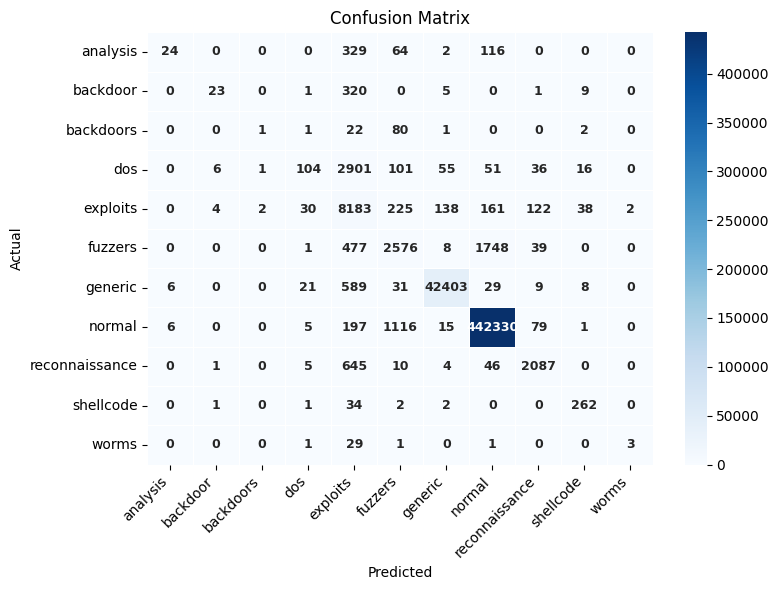

In [21]:
print(classification_report(y_test, y_pred, digits=4))
labels = mlp_model.named_steps['mlp'].classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)
# Dynamic figure/font sizing to avoid overlapping annotations
fig_w = max(8, len(labels) * 0.6)
fig_h = max(6, len(labels) * 0.5)
plt.figure(figsize=(fig_w, fig_h))
# Reduce annotation font size compared to previous version
annot_font = max(5, int(100 / max(1, len(labels))))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.6,
    linecolor='white',
    annot_kws={"fontsize": annot_font, "weight": "bold"}
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

MLP outputu ile RF outputu farkını al min yap

distilled Model oku ve izle